In [105]:
%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import causallearn
import random
from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C3'), ('C2', 'C3'), ('C2', 'C1')], \
                         cluster_bidirected_edges=[('C1', 'C2')])

In [107]:
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
#                          cluster_edges = [('C1', 'C3'), ('C2', 'C3')])

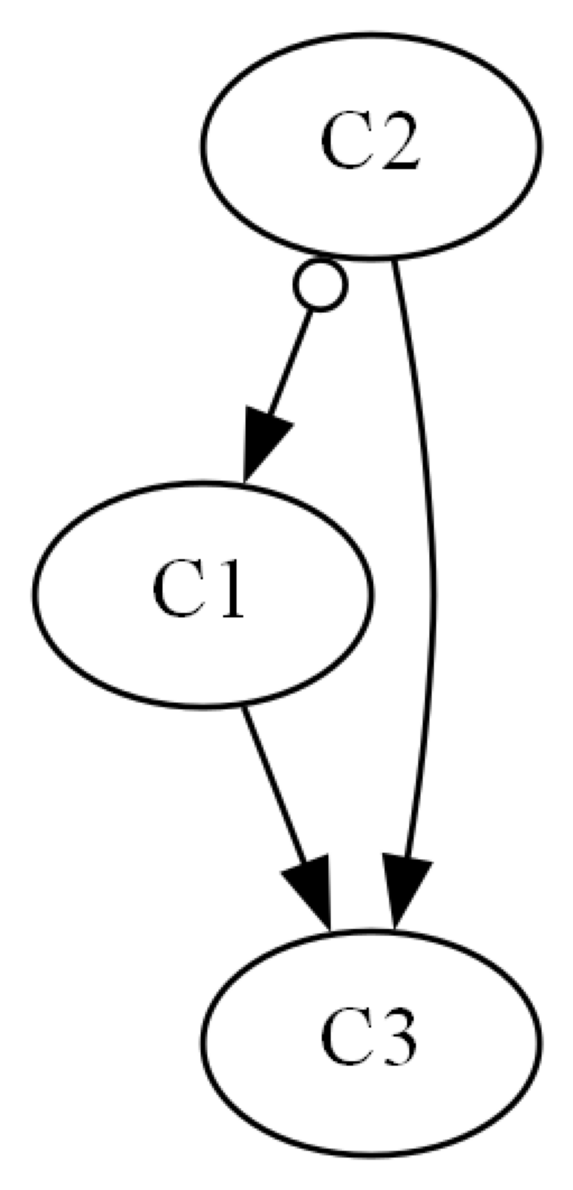

In [108]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [109]:
cluster_dag.cdag_to_mpdag()

In [110]:
cluster_dag.cluster_graph.G.get_graph_edges()[0]

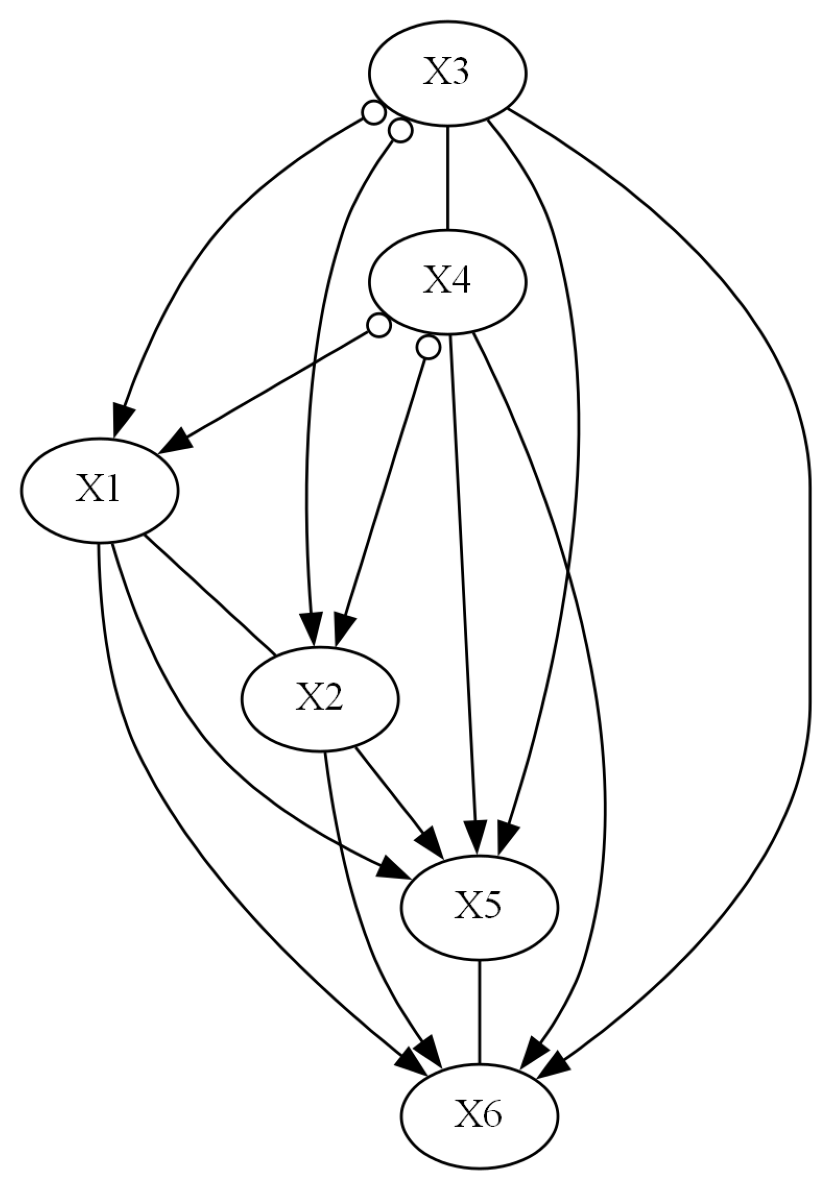

In [111]:
cluster_dag.cg.draw_pydot_graph()

In [112]:
cluster_dag.get_cluster_topological_ordering()

['C2', 'C1', 'C3']